# Week 1

## Useful functions

In [307]:
# libraries to import
import numpy as np
import matplotlib.pyplot as plt

In [308]:
# useful functions
def show_bar_plot(x_axis, y_axis, x_label, y_label, title):

    # Create bar chart
    plt.bar(x_axis, y_axis)

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Show the plot
    plt.show()
    
def show_line_plot(x_axis, y_axis, labels, x_label, y_label, title):
    """Plot a line chart with the given x and y values, and labels for the lines."""
    # Create line chart
    for y, label in zip(y_axis, labels):
        plt.plot(x_axis, y, label=label)
        plt.legend(labels)
        
    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    plt.grid()

    # Show the plot
    plt.show()

## Initial Setup

This will be the witness experiment, with the default parameters in order to have a better comparison scale.

Exploration time:  53


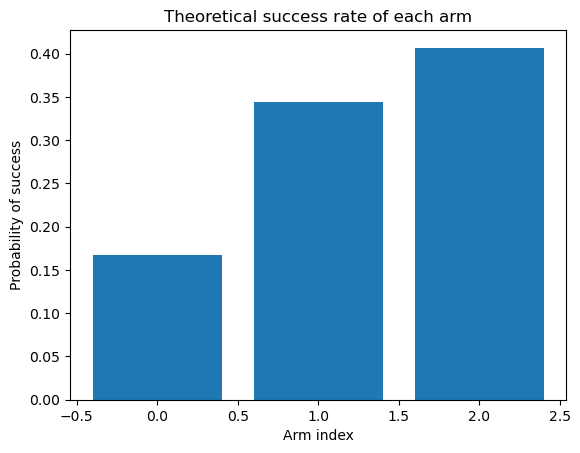

Highest probability arm:  2


In [309]:
#Initialisation of default general parameters for the Explore then Commit strategy of the Multi-Armed Bandit problem
# in the context of a slot machine

# Total number of arms
N_ARMS = 3

# Arms Probabilities repartitions
true_probs = np.random.rand(N_ARMS)
highest_prob_arm = np.argmax(true_probs)

# Number of rounds
nbr_throws = 400

# Exploration coefficient
exploration_coeff = 0.4

# Exploration phase duration
N_EXPLORATION = int((nbr_throws / N_ARMS ) * exploration_coeff)
print("Exploration time: ", N_EXPLORATION)

# reward for a win
REWARD = 1

# Print all the probabilities and the index of the highest probability
show_bar_plot(x_axis = range(len(true_probs)), y_axis = true_probs, x_label="Arm index", y_label="Probability of success", title="Theoretical success rate of each arm")
print("Highest probability arm: ", highest_prob_arm)

P(not choosing the best Arm ) = 1 - P(choosing best Arm)

Let's define the following:

H0: The zero-indexed arm has a higher probability of winning
H1: The first arm has a higher probability of winning
H2: The second arm has a higher probability of winning
H3: The third arm has a higher probability of winning
H4: The fourth arm has a higher probability of winning

We

In [310]:
# Probabililty of not choosing the best arm after the exploration time
def prob_choosing_arm(arm_index, num_arms, n_successes, n_pulls):
    if n_pulls[arm_index] == 0:
        return 1.0 / num_arms 
    return n_successes[arm_index] / n_pulls[arm_index]


In [311]:
def explore_then_commit(num_arms, exploration, max_throws, rwd, arm_probs):

    # Initialize arrays to keep track of pulls, successes, results, regrets, and values
    n_pulls = np.zeros(num_arms, dtype=int)
    n_successes = np.zeros(num_arms, dtype=int)
    results = np.zeros((num_arms, max_throws), dtype=int)
    regrets = np.zeros(max_throws, dtype=float)
    
    probs_not_best = np.zeros((num_arms, exploration), dtype=float)


    # Counter for the current regret value
    pull_counter = 0
    
    # Exploration phase for each arm
    for arm in range(num_arms):
        for i in range(exploration):

            probs_not_best[arm, i] = 1 - prob_choosing_arm(arm, num_arms, n_successes, n_pulls)
            n_pulls[arm] += 1
            pull_counter += 1
            if np.random.rand() < arm_probs[arm]:
                n_successes[arm] += 1
                reward = rwd
            else:
                reward = 0

            results[arm, n_pulls[arm] - 1] = reward
            regrets[pull_counter - 1], _, _ = compute_regret(n_pulls, arm_probs, pull_counter, 1)



    # Commit phase
    arm = np.argmax(np.where(n_pulls > 0, n_successes / n_pulls, np.nan))
    if pull_counter >= max_throws:
        return results, regrets, n_successes, probs_not_best

    for i in range(num_arms * exploration, max_throws):
        n_pulls[arm] += 1
        pull_counter += 1
        if np.random.rand() < arm_probs[arm]:
            reward = rwd
        else:
            reward = 0
        results[arm, n_pulls[arm] - 1] = reward
        regrets[pull_counter - 1], _, _ = compute_regret(n_pulls, arm_probs, pull_counter, 1)
        
    return results, regrets, n_successes, probs_not_best


Regret is calculated as the difference between the best possible reward and the reward obtained by the agent. This is simply done by a formula, WITHOUT using the actual values of success and failure at each step.

This may explain why the regret may not seem to be decreasing over the number of pulls. However, at the end of the experiment, the regret is calculated using the actual values of success and failure at each step, and the results are the same.

We could consider empirical regret and theoretical regret. The former is the difference between the best possible reward and the reward obtained by the agent, and the latter is the difference between the best possible reward and the reward obtained by the agent, calculated using the actual values of success and failure at each step.

Remainder: Lower the regret, better is the strategy.

In [312]:
# Compute the regret
def compute_regret(n_pulls, arms_probs, nbr_pulls, reward):

    # Find the maximum true probability among all arms
    max_true_prob = np.max(arms_probs)
    
    # Calculate the expected reward for the optimal arm
    expected_reward_optimal_arm = max_true_prob * nbr_pulls * reward

    # Calculate the expected reward for the learning algorithm
    expected_reward_learner = 0
    for arm in range(len(arms_probs)):
        if np.any(n_pulls[arm]):
            expected_reward_learner += arms_probs[arm] * n_pulls[arm]

    # Calculate the regret
    regret = expected_reward_optimal_arm - expected_reward_learner
    
    return regret, expected_reward_optimal_arm, expected_reward_learner


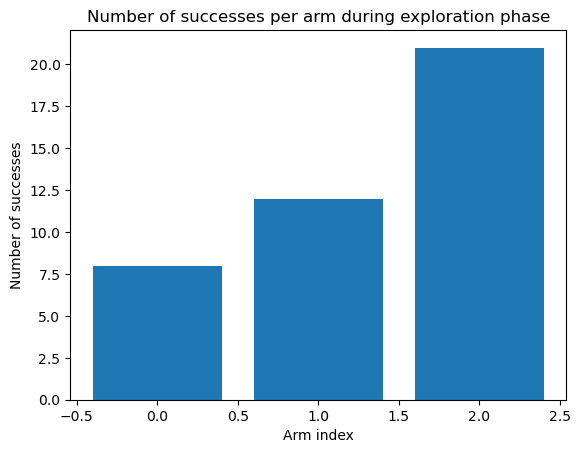

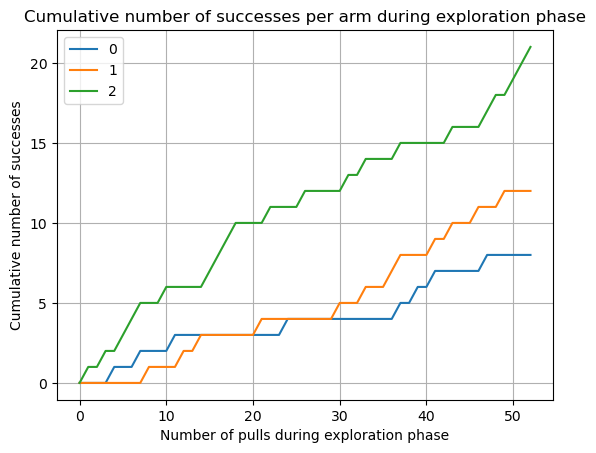

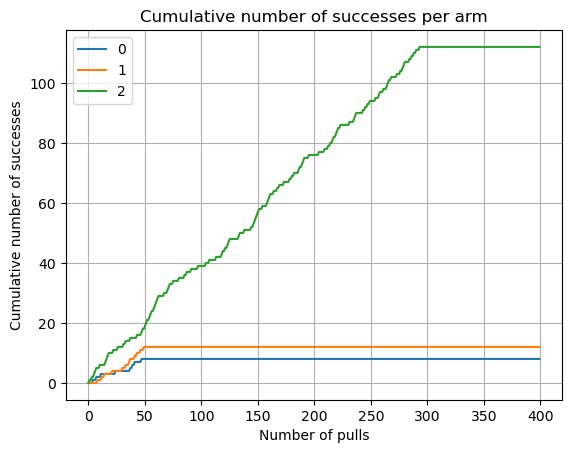

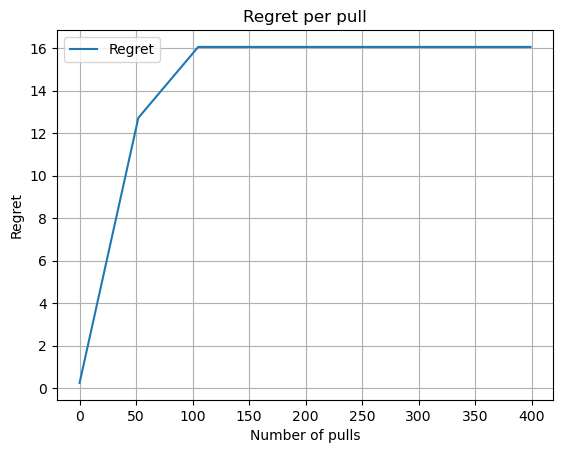

In [313]:
# Display results of the Explore as a graph of the number of successful plays per arm depending on the number of plays
results, regrets, n_successes, _ = explore_then_commit(N_ARMS, N_EXPLORATION, nbr_throws, REWARD, true_probs)

# Compute the regret and display it
regret = compute_regret(results, true_probs, nbr_throws, REWARD)

# Plot the number of successes per arm during the exploration phase
show_bar_plot(x_axis=range(N_ARMS), y_axis=n_successes, x_label="Arm index", y_label="Number of successes",
    title="Number of successes per arm during exploration phase"
) 


# Plot the cumulative number of successes per arm during the exploration phase
show_line_plot(
    x_axis=range(N_EXPLORATION),
    y_axis=np.cumsum(results[:, :N_EXPLORATION], axis=1),
    labels=range(N_ARMS),
    x_label="Number of pulls during exploration phase",
    y_label="Cumulative number of successes",
    title="Cumulative number of successes per arm during exploration phase"
)

# Plot the cumulative number of successes per arm during the exploration phase
show_line_plot(
    x_axis=range(nbr_throws),
    y_axis=np.cumsum(results, axis=1),
    labels=range(N_ARMS),
    x_label="Number of pulls",
    y_label="Cumulative number of successes",
    title="Cumulative number of successes per arm"
)

# Plot the regret
show_line_plot(
    x_axis=range(nbr_throws),
    #y_axis is the value of regrets in the array regrets, for example the first value should be the first value of the array regrets
    y_axis=[regrets],
    labels=["Regret"],
    x_label="Number of pulls",
    y_label="Regret",
    title="Regret per pull"
)

## Modifying the number of arms

In this section we will do the same as above but with a different number of arms. We will use the same number of trials and the same number of rounds.

2 arms:

Exploration time:  80


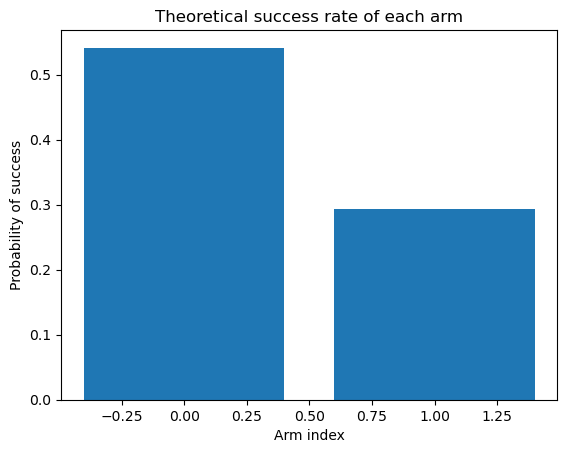

Highest probability arm:  0


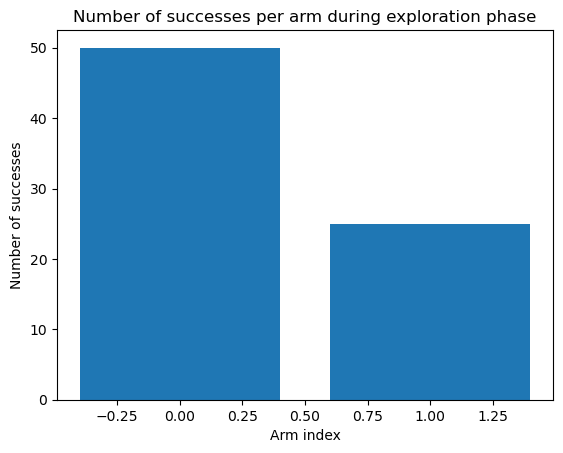

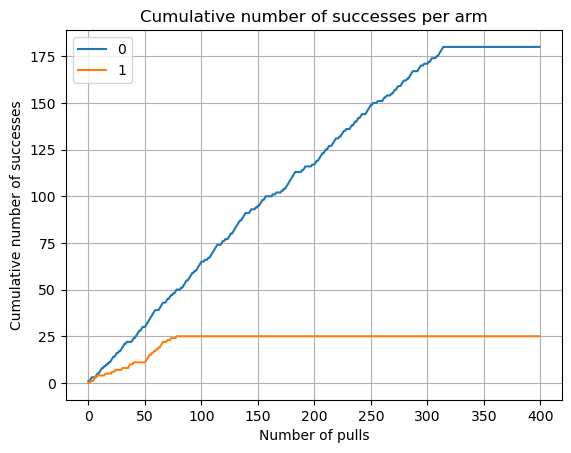

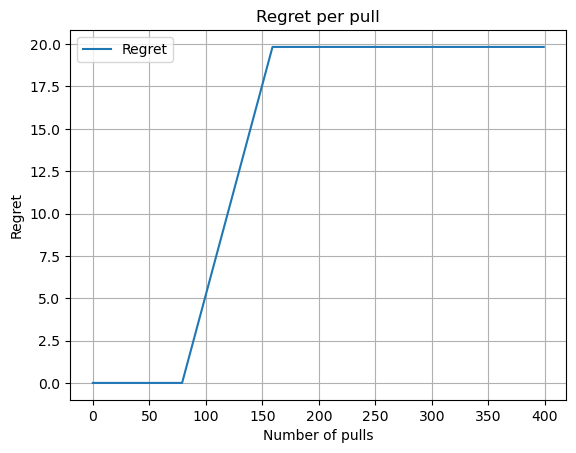

In [314]:
#Initialisation of default general parameters for the Explore then Commit strategy of the Multi-Armed Bandit problem
# in the context of a slot machine

# Total number of arms
N_ARMS = 2
N_EXPLORATION = int((nbr_throws / N_ARMS ) * exploration_coeff)
print("Exploration time: ", N_EXPLORATION)



# Arms Probabilities repartitions
true_probs = np.random.rand(N_ARMS)
highest_prob_arm = np.argmax(true_probs)

# Print all the probabilities and the index of the highest probability
show_bar_plot(x_axis = range(len(true_probs)), y_axis = true_probs, x_label="Arm index", y_label="Probability of success", title="Theoretical success rate of each arm")
print("Highest probability arm: ", highest_prob_arm)

# Display results of the Explore as a graph of the number of successful plays per arm depending on the number of plays

results, regrets, n_successes, _ = explore_then_commit(N_ARMS, N_EXPLORATION, nbr_throws, REWARD, true_probs)

# Plot the number of successes per arm during the exploration phase
show_bar_plot(
    x_axis=range(N_ARMS),
    y_axis=n_successes,
    x_label="Arm index",
    y_label="Number of successes",
    title="Number of successes per arm during exploration phase"
) 

# Plot the cumulative number of successes per arm during the exploration phase
show_line_plot(
    x_axis=range(nbr_throws),
    y_axis=np.cumsum(results, axis=1),
    labels=range(N_ARMS),
    x_label="Number of pulls",
    y_label="Cumulative number of successes",
    title="Cumulative number of successes per arm"
)

# Plot the regret
show_line_plot(
    x_axis=range(nbr_throws),
    #y_axis is the value of regrets in the array regrets, for example the first value should be the first value of the array regrets
    y_axis=[regrets],
    labels=["Regret"],
    x_label="Number of pulls",
    y_label="Regret",
    title="Regret per pull"
)

5 arms: 

Exploration time:  32


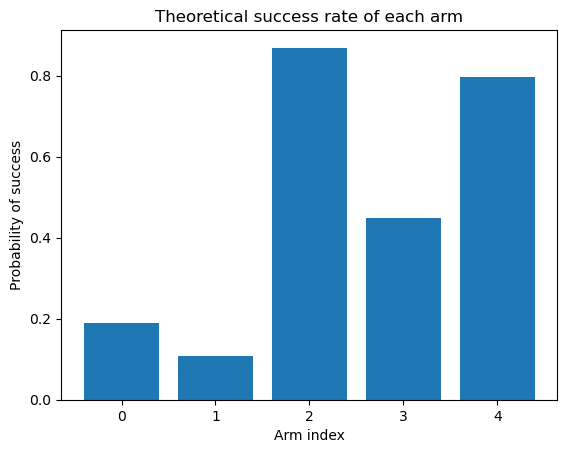

Highest probability arm:  2


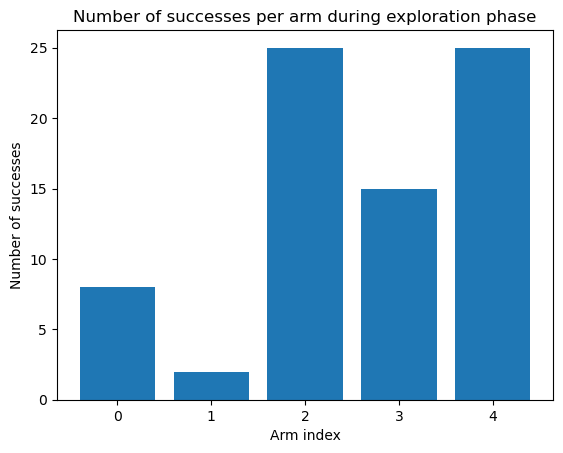

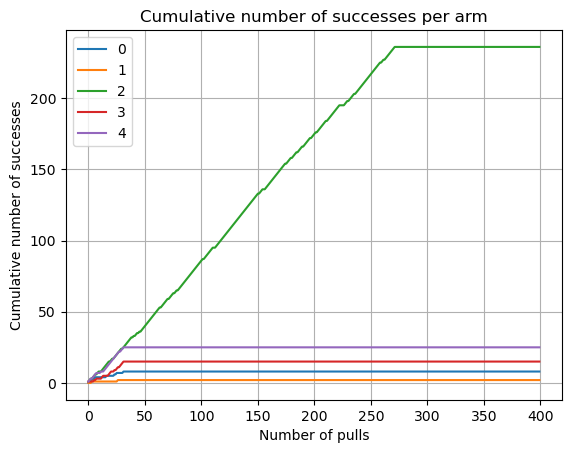

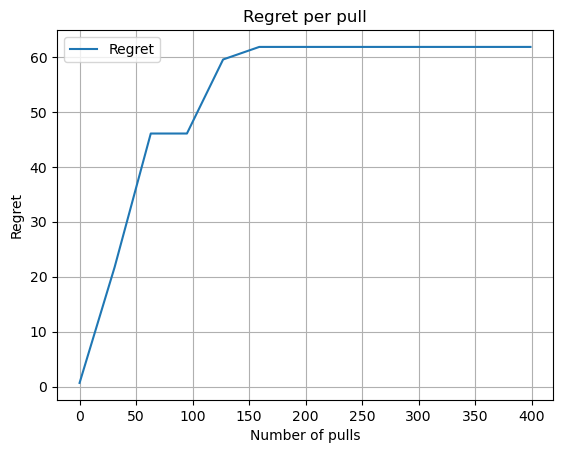

In [315]:
#Initialisation of default general parameters for the Explore then Commit strategy of the Multi-Armed Bandit problem
# in the context of a slot machine

# Total number of arms
N_ARMS = 5
N_EXPLORATION = int((nbr_throws / N_ARMS ) * exploration_coeff)
print("Exploration time: ", N_EXPLORATION)



# Arms Probabilities repartitions
true_probs = np.random.rand(N_ARMS)
highest_prob_arm = np.argmax(true_probs)

# Print all the probabilities and the index of the highest probability
show_bar_plot(x_axis = range(len(true_probs)), y_axis = true_probs, x_label="Arm index", y_label="Probability of success", title="Theoretical success rate of each arm")
print("Highest probability arm: ", highest_prob_arm)

# Display results of the Explore as a graph of the number of successful plays per arm depending on the number of plays

results, regrets, n_successes, _ = explore_then_commit(N_ARMS, N_EXPLORATION, nbr_throws, REWARD, true_probs)
# Plot the number of successes per arm during the exploration phase
show_bar_plot(
    x_axis=range(N_ARMS),
    y_axis=n_successes,
    x_label="Arm index",
    y_label="Number of successes",
    title="Number of successes per arm during exploration phase"
) 

# Plot the cumulative number of successes per arm during the exploration phase
show_line_plot(
    x_axis=range(nbr_throws),
    y_axis=np.cumsum(results, axis=1),
    labels=range(N_ARMS),
    x_label="Number of pulls",
    y_label="Cumulative number of successes",
    title="Cumulative number of successes per arm"
)

# Plot the regret
show_line_plot(
    x_axis=range(nbr_throws),
    #y_axis is the value of regrets in the array regrets, for example the first value should be the first value of the array regrets
    y_axis=[regrets],
    labels=["Regret"],
    x_label="Number of pulls",
    y_label="Regret",
    title="Regret per pull"
)

15 arms:

Exploration time:  10


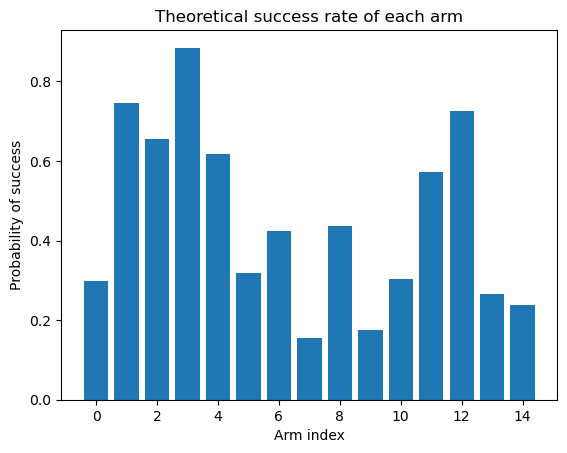

Highest probability arm:  3


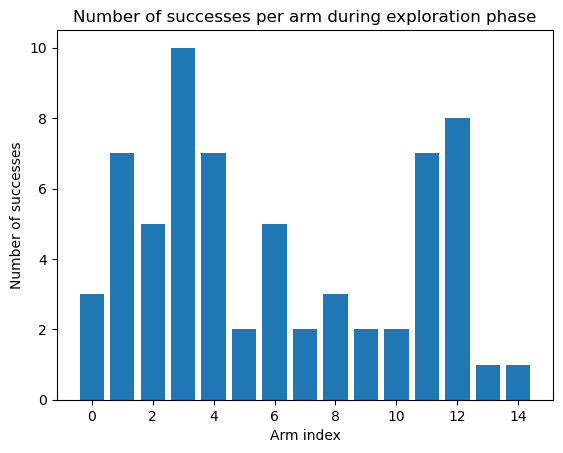

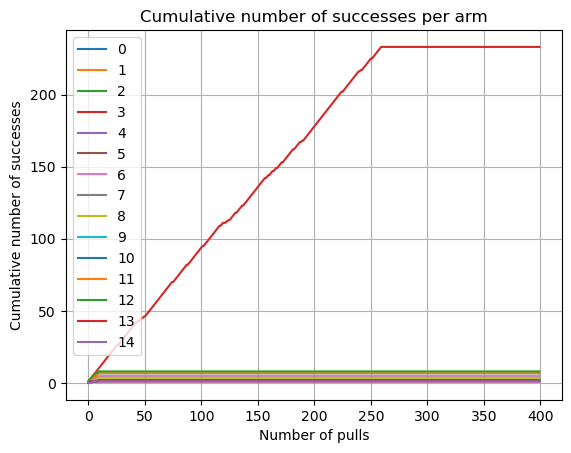

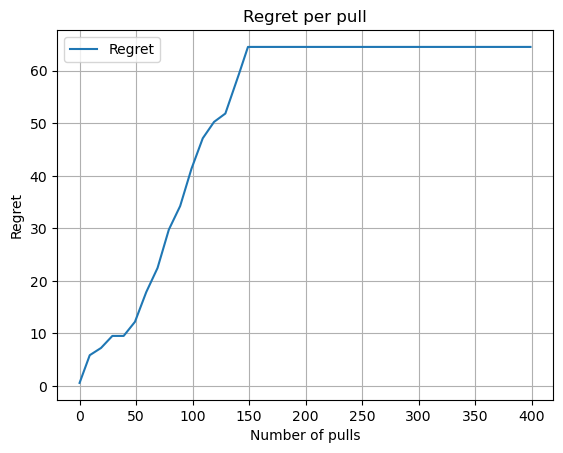

In [316]:
#Initialisation of default general parameters for the Explore then Commit strategy of the Multi-Armed Bandit problem
# in the context of a slot machine

# Total number of arms
N_ARMS = 15
N_EXPLORATION = int((nbr_throws / N_ARMS ) * exploration_coeff)

#print exploration phase
print("Exploration time: ", N_EXPLORATION)


# Arms Probabilities repartitions
true_probs = np.random.rand(N_ARMS)
highest_prob_arm = np.argmax(true_probs)

# Print all the probabilities and the index of the highest probability
show_bar_plot(x_axis = range(len(true_probs)), y_axis = true_probs, x_label="Arm index", y_label="Probability of success", title="Theoretical success rate of each arm")
print("Highest probability arm: ", highest_prob_arm)

# Display results of the Explore as a graph of the number of successful plays per arm depending on the number of plays
results, regrets, n_successes, _ = explore_then_commit(N_ARMS, N_EXPLORATION, nbr_throws, REWARD, true_probs)

# Plot the number of successes per arm during the exploration phase
show_bar_plot(
    x_axis=range(N_ARMS),
    y_axis=n_successes,
    x_label="Arm index",
    y_label="Number of successes",
    title="Number of successes per arm during exploration phase"
) 

# Plot the cumulative number of successes per arm during the exploration phase
show_line_plot(
    x_axis=range(nbr_throws),
    y_axis=np.cumsum(results, axis=1),
    labels=range(N_ARMS),
    x_label="Number of pulls",
    y_label="Cumulative number of successes",
    title="Cumulative number of successes per arm"
)

# Plot the regret
show_line_plot(
    x_axis=range(nbr_throws),
    #y_axis is the value of regrets in the array regrets, for example the first value should be the first value of the array regrets
    y_axis=[regrets],
    labels=["Regret"],
    x_label="Number of pulls",
    y_label="Regret",
    title="Regret per pull"
)

#  Week 2

## Goals and Objectives

- Generate clean regret plots.
- Choose five arms and vary the probability of success, exploration time, sub-optimality gap.
- Calculate for each setup the probability of not choosing the best arm at the commit time.
- Plot the results as a function of exploration time.


## Setup

In [317]:
#Initialisation of general parameters for the Explore then Commit strategy of the Multi-Armed Bandit problem

# Total number of arms
N_ARMS = 5

# Number of rounds
nbr_throws = 10000

# exploration time
T_EXPLORATION = [10, 100, 1000, 2000]


# reward for a win
REWARD = 1

# sub-optimality gap
GAPS = [0.01, 0.05, 0.1, 0.2, 0.5]

# Array of list of arms Probabilities repartitions
array_probs = []

# Probability repartition with sub-optimality gap
for gap in GAPS:
    # probability of success for the best arm
    p_best = 0.5 + gap

    # probability of success for the second best arm
    p_second_best = 0.5

    # calculate the other arm probabilities as random between 0 and p_second_best
    probs = np.random.rand(N_ARMS - 2) * p_second_best

    # add the best and second best arm probabilities
    probs = np.append(probs, [p_best, p_second_best])

    # shuffle the probabilities and add them to the list
    np.random.shuffle(probs)
    array_probs.append(probs)

# index of probabilities array in arms_probs
probs_index = 0
highest_prob_arm = np.argmax(array_probs[probs_index])




## Probability of choosing the best arm after the exploration time


P(not choosing Arm i) = 1 - P(choosing Arm i) = 1 - empirical success rate of Arm i

## Test 1

###  T_Exploration=10, Trials = 10000, 5 arms, 0.5 probability of success, 0.01 sub-optimality gap

[0.42492876 0.51       0.5        0.2512504  0.01349842]
Highest probability arm:  1
Exploration time:  10


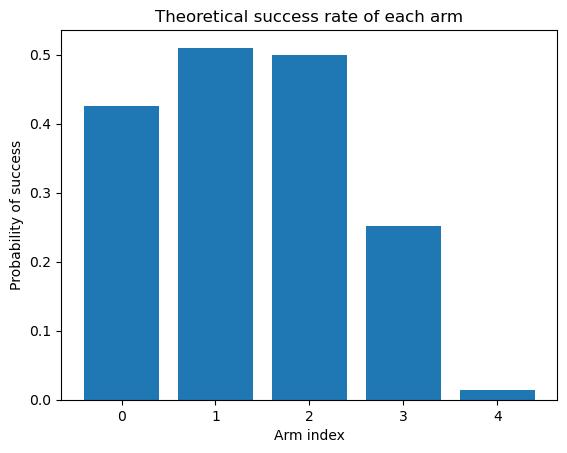

Number of successes per arm during the exploration phase:  [2 2 3 4 0]


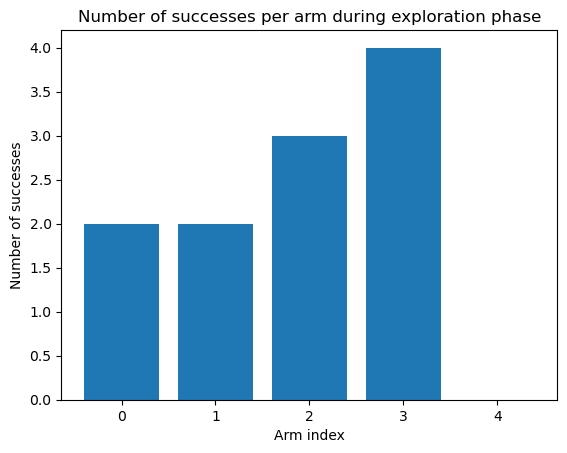

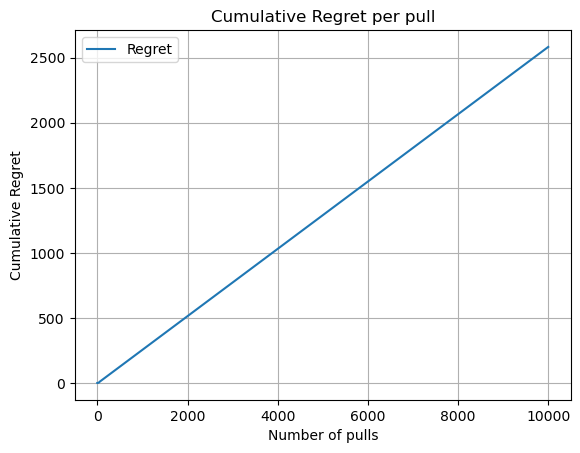

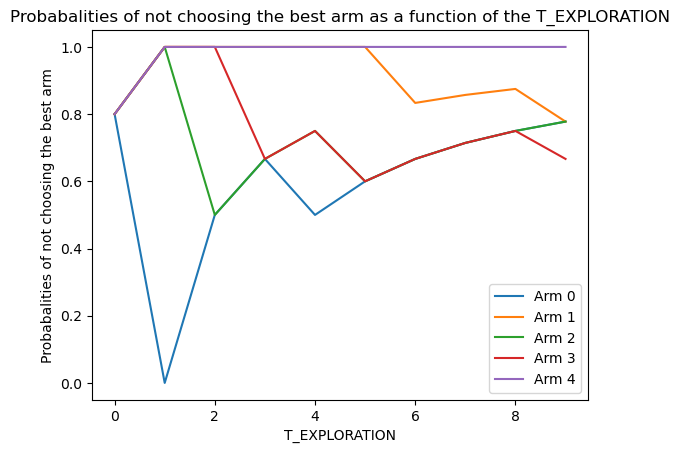

In [318]:
# Display results of the Explore as a graph of the number of successful plays per arm depending on the number of plays
results, regrets, n_successes, not_best_probs = explore_then_commit(N_ARMS, T_EXPLORATION[0], nbr_throws, 1, array_probs[probs_index])



print(array_probs[probs_index])
print("Highest probability arm: ", highest_prob_arm)

# Print exploration time
print("Exploration time: ", T_EXPLORATION[0])

# Print all the probabilities and the index of the highest probability
show_bar_plot(x_axis = range(len(array_probs[probs_index])), y_axis = array_probs[probs_index], x_label="Arm index", y_label="Probability of success", title="Theoretical success rate of each arm")

# Print number of successes per arm during the exploration phase
print("Number of successes per arm during the exploration phase: ", n_successes)

# Plot the number of successes per arm during the exploration phase
show_bar_plot(x_axis=range(N_ARMS), y_axis=n_successes, x_label="Arm index", y_label="Number of successes", title="Number of successes per arm during exploration phase") 

# Plot the regret
show_line_plot(x_axis=range(nbr_throws), y_axis=[regrets], labels=["Regret"], x_label="Number of pulls", y_label="Cumulative Regret", title="Cumulative Regret per pull")

plt.xlabel("T_EXPLORATION")
plt.ylabel("Probabalities of not choosing the best arm" )
plt.title("Probabalities of not choosing the best arm as a function of the T_EXPLORATION")

x = range(T_EXPLORATION[0])
y = []
labels = []
for i in range(N_ARMS):
    y.append(not_best_probs[i])
    labels.append("Arm " + str(i))
    #print("Probability of not choosing the best arm: ", not_best_probs[i])
    
for y_arr, label in zip(y, labels):
    plt.plot(x, y_arr, label=label)

# Show the plot
plt.legend(labels)
plt.show()

### T_Exploration=100, Trials = 10000, 5 arms, 0.5 probability of success, 0.01 sub-optimality gap

Exploration time:  100
Number of successes per arm during the exploration phase:  [46 51 64 20  4]


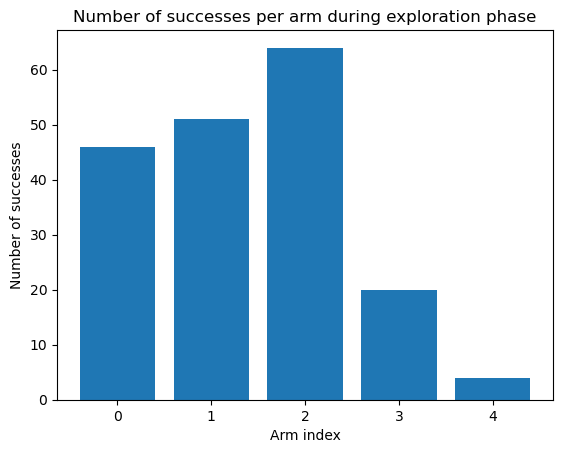

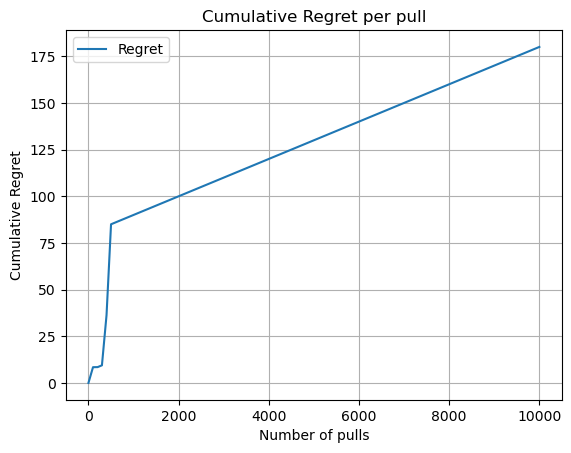

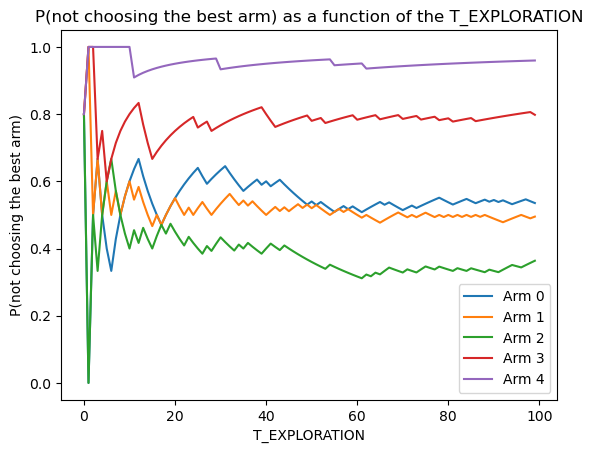

In [319]:
# Display results of the Explore as a graph of the number of successful plays per arm depending on the number of plays
results, regrets, n_successes, not_best_probs = explore_then_commit(N_ARMS, T_EXPLORATION[1], nbr_throws, 1, array_probs[probs_index])

# Print exploration time
print("Exploration time: ", T_EXPLORATION[1])

# Print number of successes per arm during the exploration phase
print("Number of successes per arm during the exploration phase: ", n_successes)

# Plot the number of successes per arm during the exploration phase
show_bar_plot(x_axis=range(N_ARMS), y_axis=n_successes, x_label="Arm index", y_label="Number of successes", title="Number of successes per arm during exploration phase") 

# Plot the regret
show_line_plot(x_axis=range(nbr_throws), y_axis=[regrets], labels=["Regret"], x_label="Number of pulls", y_label="Cumulative Regret", title="Cumulative Regret per pull")

plt.xlabel("T_EXPLORATION")
plt.ylabel("P(not choosing the best arm)" )
plt.title("P(not choosing the best arm) as a function of the T_EXPLORATION")
x = range(T_EXPLORATION[1])
y = []
labels = []
for i in range(N_ARMS):
    y.append(not_best_probs[i])
    labels.append("Arm " + str(i))
    #print("Probability of not choosing the best arm: ", not_best_probs[i])
    
for y_arr, label in zip(y, labels):
    plt.plot(x, y_arr, label=label)

#plt.plot(not_best_probs[i])
# Show the plot
plt.legend(labels)
plt.show()

### T_Exploration=1000, Trials = 10000, 5 arms, 0.5 probability of success, 0.01 sub-optimality gap

Exploration time:  1000
Number of successes per arm during the exploration phase:  [442 509 509 258   9]


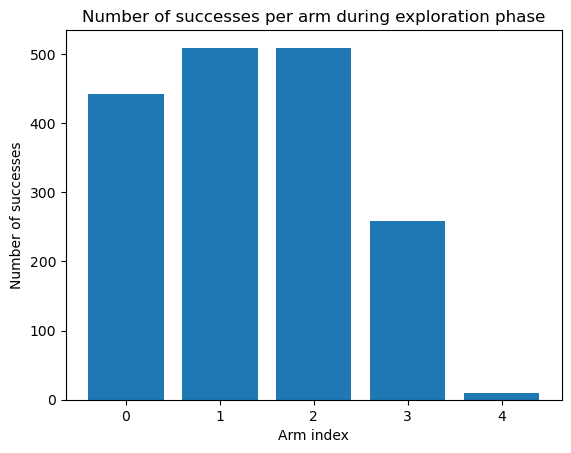

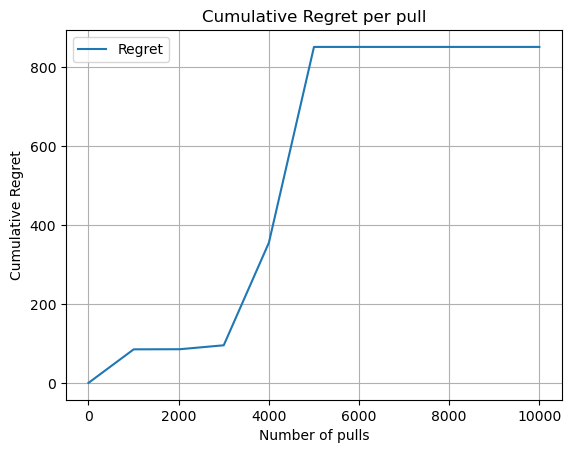

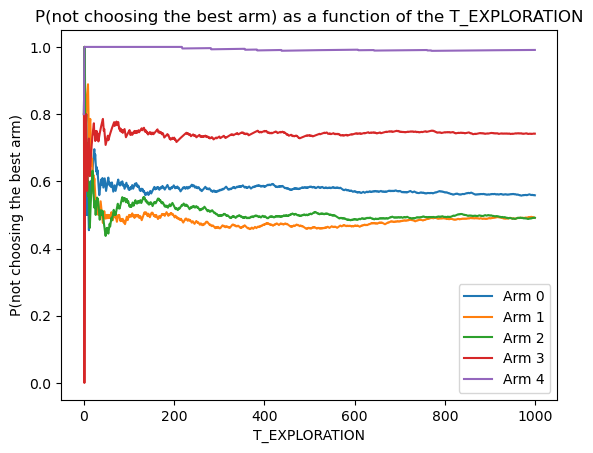

In [320]:
# Display results of the Explore as a graph of the number of successful plays per arm depending on the number of plays
results, regrets, n_successes, not_best_probs = explore_then_commit(N_ARMS, T_EXPLORATION[2], nbr_throws, 1, array_probs[probs_index])

# Print exploration time
print("Exploration time: ", T_EXPLORATION[2])

# Print number of successes per arm during the exploration phase
print("Number of successes per arm during the exploration phase: ", n_successes)

# Plot the number of successes per arm during the exploration phase
show_bar_plot(x_axis=range(N_ARMS), y_axis=n_successes, x_label="Arm index", y_label="Number of successes", title="Number of successes per arm during exploration phase") 

# Plot the regret
show_line_plot(x_axis=range(nbr_throws), y_axis=[regrets], labels=["Regret"], x_label="Number of pulls", y_label="Cumulative Regret", title="Cumulative Regret per pull")

plt.xlabel("T_EXPLORATION")
plt.ylabel("P(not choosing the best arm)" )
plt.title("P(not choosing the best arm) as a function of the T_EXPLORATION")
x = range(T_EXPLORATION[2])
y = []
labels = []
for i in range(N_ARMS):
    y.append(not_best_probs[i])
    labels.append("Arm " + str(i))
    #print("Probability of not choosing the best arm: ", not_best_probs[i])
    
for y_arr, label in zip(y, labels):
    plt.plot(x, y_arr, label=label)

#plt.plot(not_best_probs[i])
# Show the plot
plt.legend(labels)
plt.show()

### T_Exploration=2000, Trials = 10000, 5 arms, 0.5 probability of success, 0.01 sub-optimality gap

Exploration time:  2000
Number of successes per arm during the exploration phase:  [ 813 1016  938  508   29]


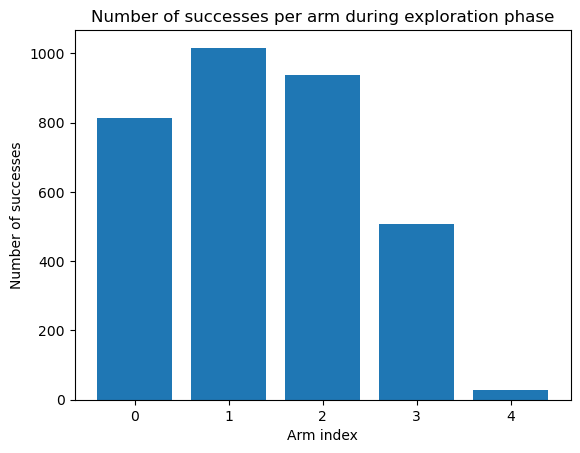

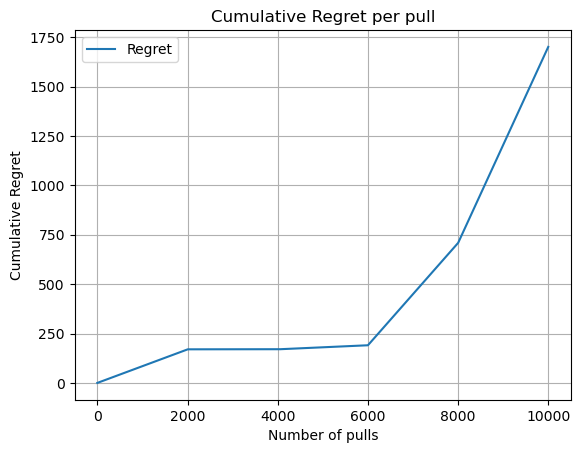

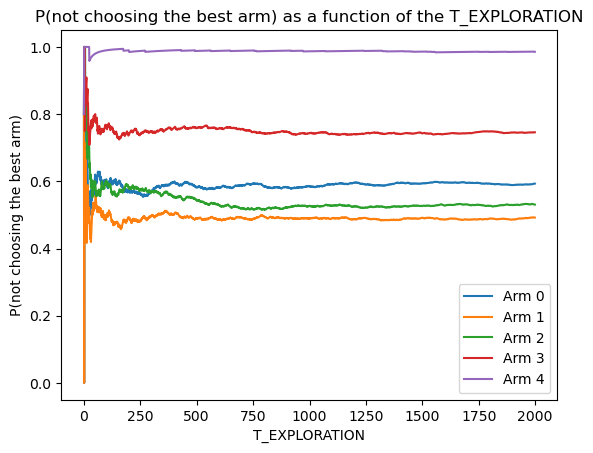

In [321]:
# Display results of the Explore as a graph of the number of successful plays per arm depending on the number of plays
results, regrets, n_successes, not_best_probs = explore_then_commit(N_ARMS, T_EXPLORATION[3], nbr_throws, 1, array_probs[probs_index])

# Print exploration time
print("Exploration time: ", T_EXPLORATION[3])

# Print number of successes per arm during the exploration phase
print("Number of successes per arm during the exploration phase: ", n_successes)

# Plot the number of successes per arm during the exploration phase
show_bar_plot(x_axis=range(N_ARMS), y_axis=n_successes, x_label="Arm index", y_label="Number of successes", title="Number of successes per arm during exploration phase") 

# Plot the regret
show_line_plot(x_axis=range(nbr_throws), y_axis=[regrets], labels=["Regret"], x_label="Number of pulls", y_label="Cumulative Regret", title="Cumulative Regret per pull")

# Plot the probability of not choosing the best arm as a function of the T_EXPLORATION, use the x_axis of not_best_probs as x_axis and the y_axis of not_best_probs as y_axis 
plt.xlabel("T_EXPLORATION")
plt.ylabel("P(not choosing the best arm)" )
plt.title("P(not choosing the best arm) as a function of the T_EXPLORATION")
x = range(T_EXPLORATION[3])
y = []
labels = []
for i in range(N_ARMS):
    y.append(not_best_probs[i])
    labels.append("Arm " + str(i))
    #print("Probability of not choosing the best arm: ", not_best_probs[i])
    
for y_arr, label in zip(y, labels):
    plt.plot(x, y_arr, label=label)

#plt.plot(not_best_probs[i])
# Show the plot
plt.legend(labels)
plt.show()

## Test 2

### T_Exploration=10, Trials = 10000, 5 arms, 0.5 probability of success, 0.1 sub-optimality gap

[0.5        0.4561246  0.6        0.33475575 0.14480455]
Highest probability arm:  1
Exploration time:  10


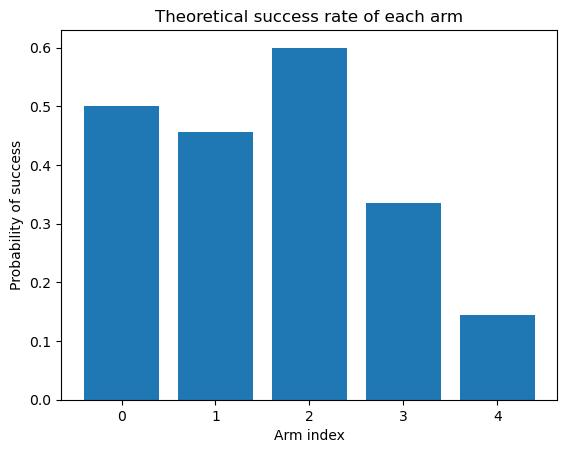

Number of successes per arm during the exploration phase:  [6 7 4 5 0]


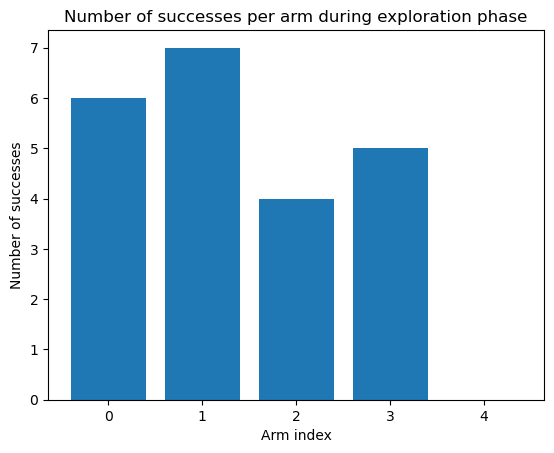

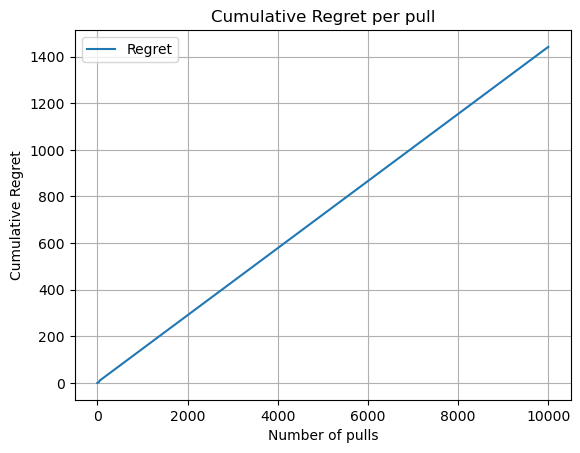

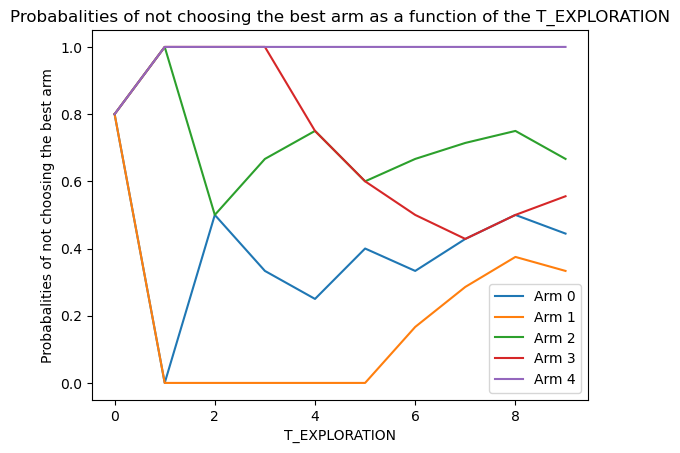

In [322]:
probs_index = 2

# Display results of the Explore as a graph of the number of successful plays per arm depending on the number of plays
results, regrets, n_successes, not_best_probs = explore_then_commit(N_ARMS, T_EXPLORATION[0], nbr_throws, 1, array_probs[probs_index])



print(array_probs[probs_index])
print("Highest probability arm: ", highest_prob_arm)

# Print exploration time
print("Exploration time: ", T_EXPLORATION[0])

# Print all the probabilities and the index of the highest probability
show_bar_plot(x_axis = range(len(array_probs[probs_index])), y_axis = array_probs[probs_index], x_label="Arm index", y_label="Probability of success", title="Theoretical success rate of each arm")

# Print number of successes per arm during the exploration phase
print("Number of successes per arm during the exploration phase: ", n_successes)

# Plot the number of successes per arm during the exploration phase
show_bar_plot(x_axis=range(N_ARMS), y_axis=n_successes, x_label="Arm index", y_label="Number of successes", title="Number of successes per arm during exploration phase") 

# Plot the regret
show_line_plot(x_axis=range(nbr_throws), y_axis=[regrets], labels=["Regret"], x_label="Number of pulls", y_label="Cumulative Regret", title="Cumulative Regret per pull")

plt.xlabel("T_EXPLORATION")
plt.ylabel("Probabalities of not choosing the best arm" )
plt.title("Probabalities of not choosing the best arm as a function of the T_EXPLORATION")

x = range(T_EXPLORATION[0])
y = []
labels = []
for i in range(N_ARMS):
    y.append(not_best_probs[i])
    labels.append("Arm " + str(i))
    #print("Probability of not choosing the best arm: ", not_best_probs[i])
    
for y_arr, label in zip(y, labels):
    plt.plot(x, y_arr, label=label)

# Show the plot
plt.legend(labels)
plt.show()

### T_Exploration=100, Trials = 10000, 5 arms, 0.5 probability of success, 0.1 sub-optimality gap

Exploration time:  100
Number of successes per arm during the exploration phase:  [50 45 68 42 17]


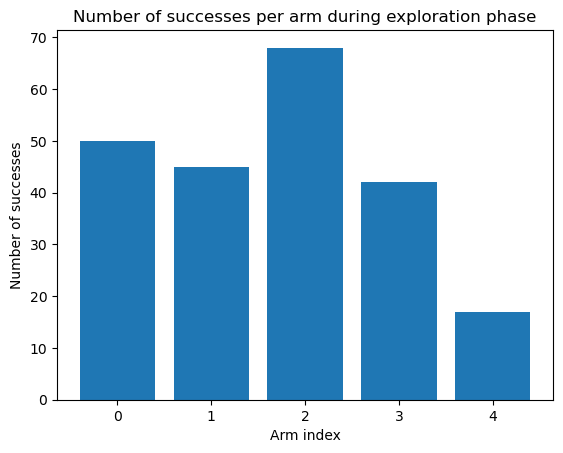

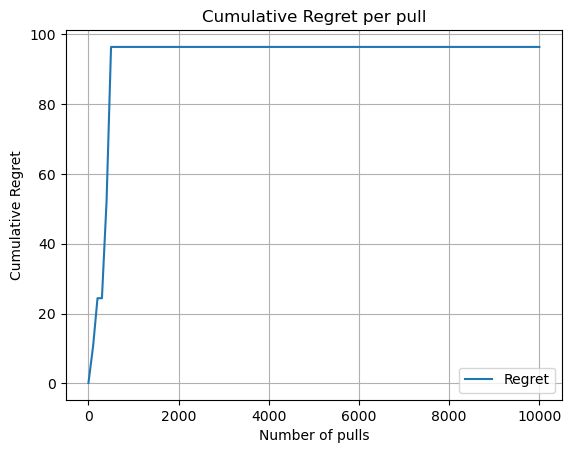

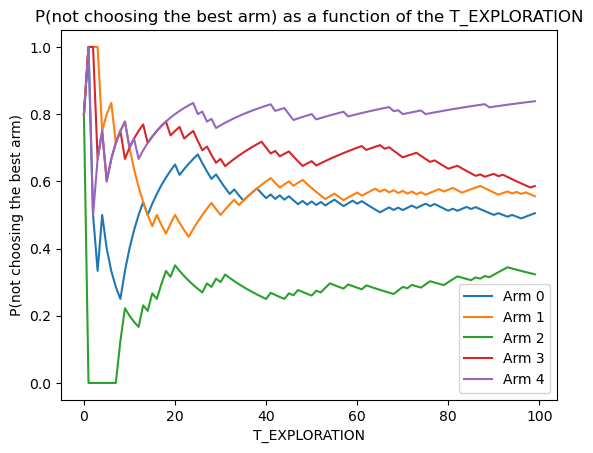

In [323]:
# Display results of the Explore as a graph of the number of successful plays per arm depending on the number of plays
results, regrets, n_successes, not_best_probs = explore_then_commit(N_ARMS, T_EXPLORATION[1], nbr_throws, 1, array_probs[probs_index])

# Print exploration time
print("Exploration time: ", T_EXPLORATION[1])

# Print number of successes per arm during the exploration phase
print("Number of successes per arm during the exploration phase: ", n_successes)

# Plot the number of successes per arm during the exploration phase
show_bar_plot(x_axis=range(N_ARMS), y_axis=n_successes, x_label="Arm index", y_label="Number of successes", title="Number of successes per arm during exploration phase") 

# Plot the regret
show_line_plot(x_axis=range(nbr_throws), y_axis=[regrets], labels=["Regret"], x_label="Number of pulls", y_label="Cumulative Regret", title="Cumulative Regret per pull")

plt.xlabel("T_EXPLORATION")
plt.ylabel("P(not choosing the best arm)" )
plt.title("P(not choosing the best arm) as a function of the T_EXPLORATION")
x = range(T_EXPLORATION[1])
y = []
labels = []
for i in range(N_ARMS):
    y.append(not_best_probs[i])
    labels.append("Arm " + str(i))
    
for y_arr, label in zip(y, labels):
    plt.plot(x, y_arr, label=label)

#plt.plot(not_best_probs[i])
# Show the plot
plt.legend(labels)
plt.show()

### T_Exploration=1000, Trials = 10000, 5 arms, 0.5 probability of success, 0.1 sub-optimality gap

Exploration time:  1000
Number of successes per arm during the exploration phase:  [516 455 590 326 139]


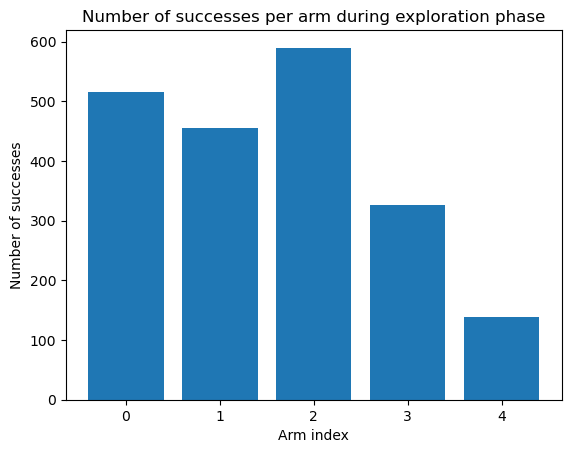

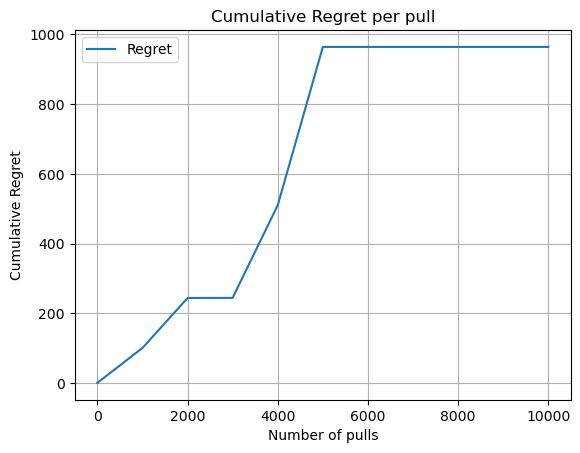

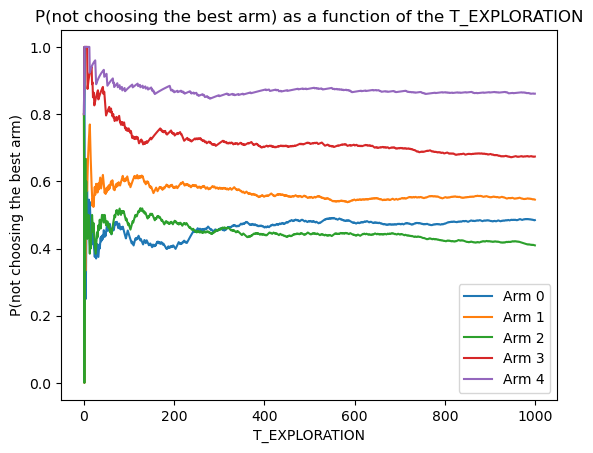

In [324]:
# Display results of the Explore as a graph of the number of successful plays per arm depending on the number of plays
results, regrets, n_successes, not_best_probs = explore_then_commit(N_ARMS, T_EXPLORATION[2], nbr_throws, 1, array_probs[probs_index])

# Print exploration time
print("Exploration time: ", T_EXPLORATION[2])

# Print number of successes per arm during the exploration phase
print("Number of successes per arm during the exploration phase: ", n_successes)

# Plot the number of successes per arm during the exploration phase
show_bar_plot(x_axis=range(N_ARMS), y_axis=n_successes, x_label="Arm index", y_label="Number of successes", title="Number of successes per arm during exploration phase") 

# Plot the regret
show_line_plot(x_axis=range(nbr_throws), y_axis=[regrets], labels=["Regret"], x_label="Number of pulls", y_label="Cumulative Regret", title="Cumulative Regret per pull")

plt.xlabel("T_EXPLORATION")
plt.ylabel("P(not choosing the best arm)" )
plt.title("P(not choosing the best arm) as a function of the T_EXPLORATION")
x = range(T_EXPLORATION[2])
y = []
labels = []
for i in range(N_ARMS):
    y.append(not_best_probs[i])
    labels.append("Arm " + str(i))
    #print("Probability of not choosing the best arm: ", not_best_probs[i])
    
for y_arr, label in zip(y, labels):
    plt.plot(x, y_arr, label=label)

#plt.plot(not_best_probs[i])
# Show the plot
plt.legend(labels)
plt.show()

## TEST 3

### T_Exploration=10, Trials = 10000, 5 arms, 0.5 probability of success, 0.2 sub-optimality gap

[0.37461216 0.7        0.01367551 0.5        0.24550331]
Highest probability arm:  1
Exploration time:  10


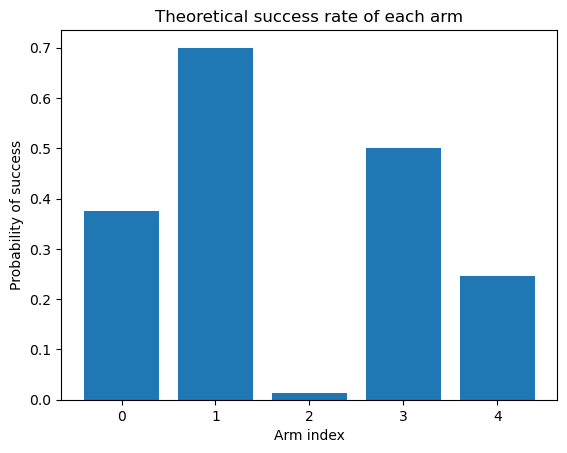

Number of successes per arm during the exploration phase:  [3 7 0 8 2]


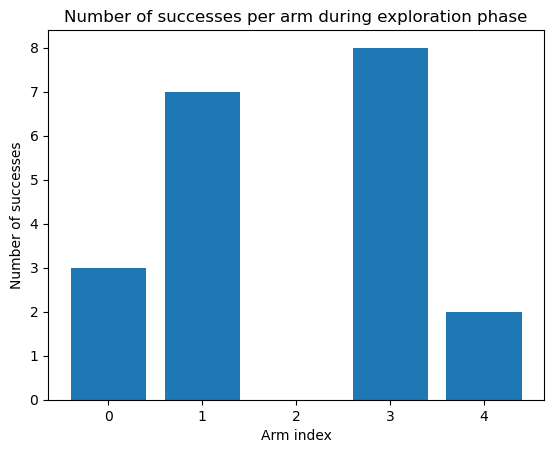

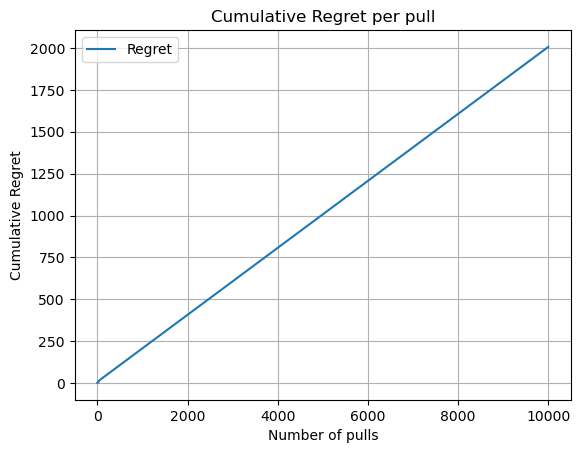

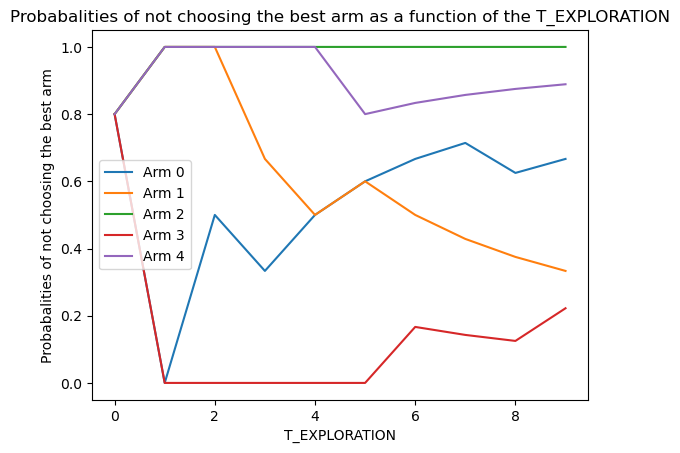

In [325]:
probs_index = 3

# Display results of the Explore as a graph of the number of successful plays per arm depending on the number of plays
results, regrets, n_successes, not_best_probs = explore_then_commit(N_ARMS, T_EXPLORATION[0], nbr_throws, 1, array_probs[probs_index])



print(array_probs[probs_index])
print("Highest probability arm: ", highest_prob_arm)

# Print exploration time
print("Exploration time: ", T_EXPLORATION[0])

# Print all the probabilities and the index of the highest probability
show_bar_plot(x_axis = range(len(array_probs[probs_index])), y_axis = array_probs[probs_index], x_label="Arm index", y_label="Probability of success", title="Theoretical success rate of each arm")

# Print number of successes per arm during the exploration phase
print("Number of successes per arm during the exploration phase: ", n_successes)

# Plot the number of successes per arm during the exploration phase
show_bar_plot(x_axis=range(N_ARMS), y_axis=n_successes, x_label="Arm index", y_label="Number of successes", title="Number of successes per arm during exploration phase") 

# Plot the regret
show_line_plot(x_axis=range(nbr_throws), y_axis=[regrets], labels=["Regret"], x_label="Number of pulls", y_label="Cumulative Regret", title="Cumulative Regret per pull")

plt.xlabel("T_EXPLORATION")
plt.ylabel("Probabalities of not choosing the best arm" )
plt.title("Probabalities of not choosing the best arm as a function of the T_EXPLORATION")

x = range(T_EXPLORATION[0])
y = []
labels = []
for i in range(N_ARMS):
    y.append(not_best_probs[i])
    labels.append("Arm " + str(i))
    #print("Probability of not choosing the best arm: ", not_best_probs[i])
    
for y_arr, label in zip(y, labels):
    plt.plot(x, y_arr, label=label)

# Show the plot
plt.legend(labels)
plt.show()

### T_Exploration=100, Trials = 10000, 5 arms, 0.5 probability of success, 0.2 sub-optimality gap

Exploration time:  100
Number of successes per arm during the exploration phase:  [33 68  2 58 31]


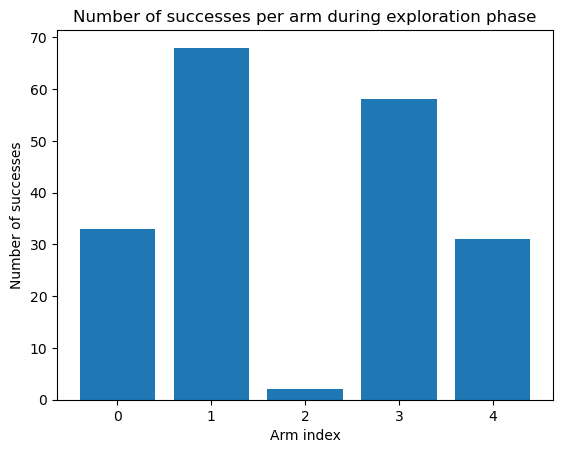

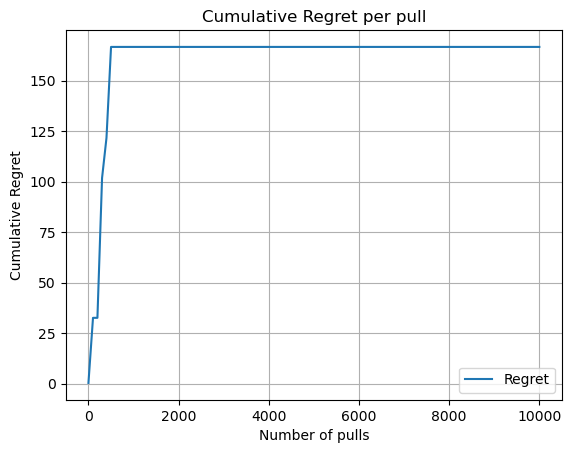

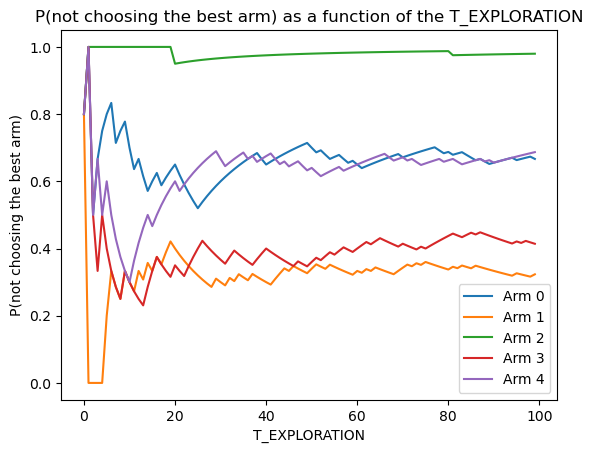

In [326]:
# Display results of the Explore as a graph of the number of successful plays per arm depending on the number of plays
results, regrets, n_successes, not_best_probs = explore_then_commit(N_ARMS, T_EXPLORATION[1], nbr_throws, 1, array_probs[probs_index])

# Print exploration time
print("Exploration time: ", T_EXPLORATION[1])

# Print number of successes per arm during the exploration phase
print("Number of successes per arm during the exploration phase: ", n_successes)

# Plot the number of successes per arm during the exploration phase
show_bar_plot(x_axis=range(N_ARMS), y_axis=n_successes, x_label="Arm index", y_label="Number of successes", title="Number of successes per arm during exploration phase") 

# Plot the regret
show_line_plot(x_axis=range(nbr_throws), y_axis=[regrets], labels=["Regret"], x_label="Number of pulls", y_label="Cumulative Regret", title="Cumulative Regret per pull")

plt.xlabel("T_EXPLORATION")
plt.ylabel("P(not choosing the best arm)" )
plt.title("P(not choosing the best arm) as a function of the T_EXPLORATION")
x = range(T_EXPLORATION[1])
y = []
labels = []
for i in range(N_ARMS):
    y.append(not_best_probs[i])
    labels.append("Arm " + str(i))
    
for y_arr, label in zip(y, labels):
    plt.plot(x, y_arr, label=label)

#plt.plot(not_best_probs[i])
# Show the plot
plt.legend(labels)
plt.show()

### T_Exploration=1000, Trials = 10000, 5 arms, 0.5 probability of success, 0.2 sub-optimality gap

Exploration time:  2000
Number of successes per arm during the exploration phase:  [ 708 1403   27  985  486]


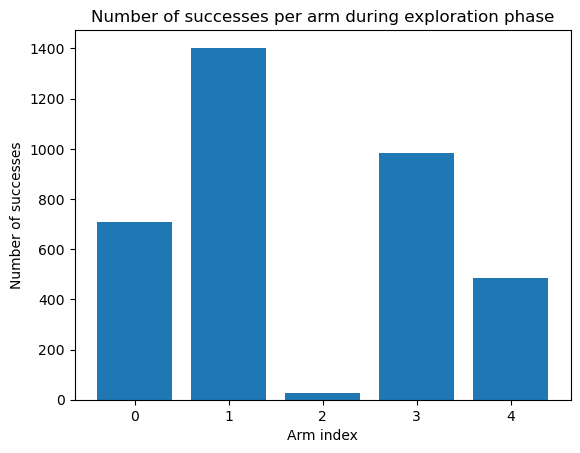

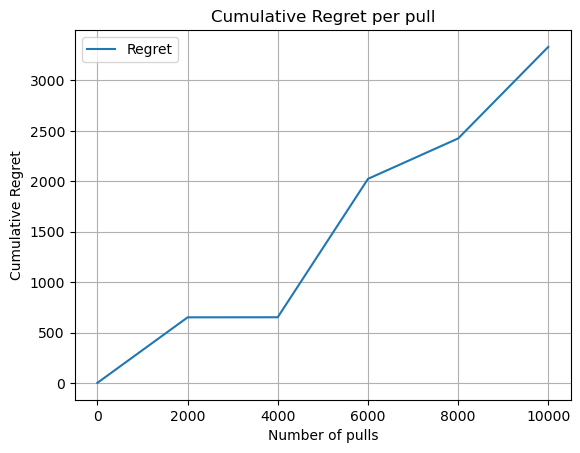

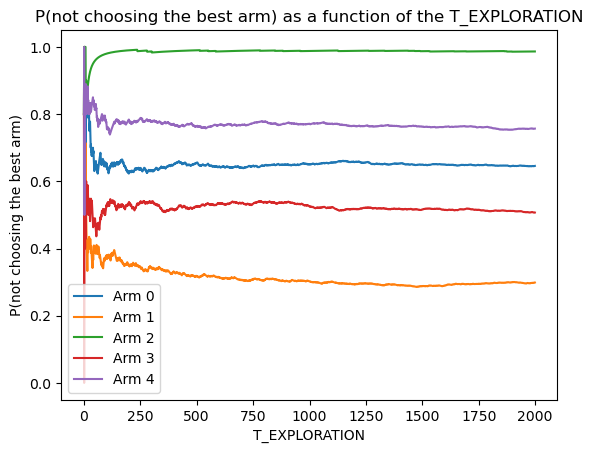

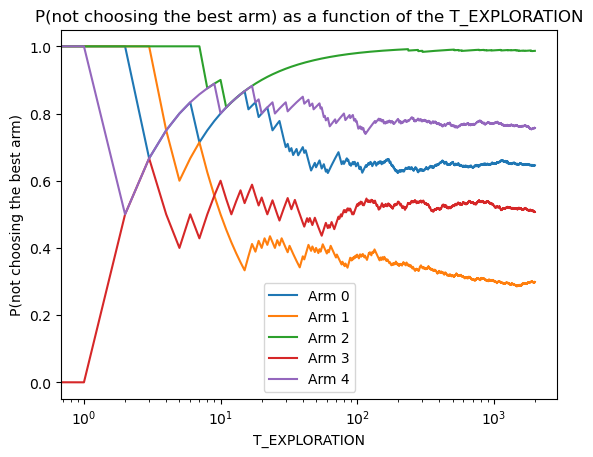

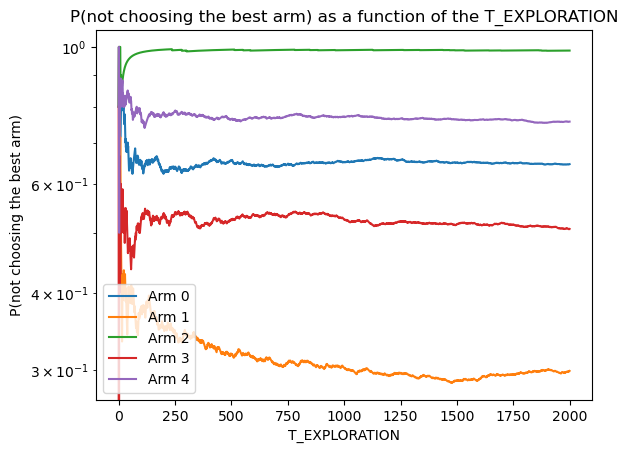

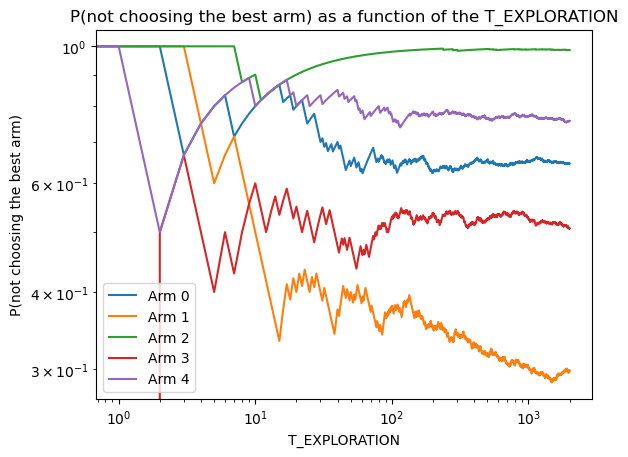

In [327]:
# Display results of the Explore as a graph of the number of successful plays per arm depending on the number of plays
results, regrets, n_successes, not_best_probs = explore_then_commit(N_ARMS, T_EXPLORATION[3], nbr_throws, 1, array_probs[probs_index])

# Print exploration time
print("Exploration time: ", T_EXPLORATION[3])

# Print number of successes per arm during the exploration phase
print("Number of successes per arm during the exploration phase: ", n_successes)

# Plot the number of successes per arm during the exploration phase
show_bar_plot(x_axis=range(N_ARMS), y_axis=n_successes, x_label="Arm index", y_label="Number of successes", title="Number of successes per arm during exploration phase") 

# Plot the regret
show_line_plot(x_axis=range(nbr_throws), y_axis=[regrets], labels=["Regret"], x_label="Number of pulls", y_label="Cumulative Regret", title="Cumulative Regret per pull")

plt.xlabel("T_EXPLORATION")
plt.ylabel("P(not choosing the best arm)" )
plt.title("P(not choosing the best arm) as a function of the T_EXPLORATION")
x = range(T_EXPLORATION[3])
y = []
labels = []
for i in range(N_ARMS):
    y.append(not_best_probs[i])
    labels.append("Arm " + str(i))
    #print("Probability of not choosing the best arm: ", not_best_probs[i])
    
for y_arr, label in zip(y, labels):
    plt.plot(x, y_arr, label=label)

#plt.plot(not_best_probs[i])
# Show the plot
plt.legend(labels)
plt.show()

# log x scale
plt.xlabel("T_EXPLORATION")
plt.ylabel("P(not choosing the best arm)")
plt.title("P(not choosing the best arm) as a function of the T_EXPLORATION")
x = range(T_EXPLORATION[3])
y = []
labels = []
for i in range(N_ARMS):
    y.append(not_best_probs[i])
    labels.append("Arm " + str(i))

for y_arr, label in zip(y, labels):
    plt.plot(x, y_arr, label=label)
plt.xscale("log")
plt.legend(labels)
plt.show()

# log y scale 
plt.xlabel("T_EXPLORATION")
plt.ylabel("P(not choosing the best arm)")
plt.title("P(not choosing the best arm) as a function of the T_EXPLORATION")
x = range(T_EXPLORATION[3])
y = []
labels = []
for i in range(N_ARMS):
    y.append(not_best_probs[i])
    labels.append("Arm " + str(i))

for y_arr, label in zip(y, labels):
    plt.plot(x, y_arr, label=label)

plt.yscale("log")
plt.legend(labels)
plt.show()

#both log_scale
plt.xlabel("T_EXPLORATION")
plt.ylabel("P(not choosing the best arm)")
plt.title("P(not choosing the best arm) as a function of the T_EXPLORATION")
x = range(T_EXPLORATION[3])
y = []
labels = []
for i in range(N_ARMS):
    y.append(not_best_probs[i])
    labels.append("Arm " + str(i))

for y_arr, label in zip(y, labels):
    plt.plot(x, y_arr, label=label)

plt.xscale("log")
plt.yscale("log")
plt.legend(labels)
plt.show()

# Week 3

## Goals and Objectives

- The success probability of explore-then-commit algo, as a function of sub-optimality gap and exploration time. Of course, this is also averaged over 50-100 runs.

## Setup

In [328]:
#Initialisation of general parameters for the Explore then Commit strategy of the Multi-Armed Bandit problem

# Total number of arms
N_ARMS = 5

# Number of rounds
nbr_throws = 10000

# exploration time
T_EXPLORATION = 10000


# reward for a win
REWARD = 1

# sub-optimality gap
GAPS = [0.01, 0.1, 0.2]

# Array of list of arms Probabilities repartitions
array_probs = []

# Probability repartition with sub-optimality gap
for gap in GAPS:
    # probability of success for the best arm
    p_best = 0.5 + gap

    # probability of success for the second best arm
    p_second_best = 0.5

    # calculate the other arm probabilities as random between 0 and p_second_best
    probs = np.random.rand(N_ARMS - 2) * p_second_best

    # add the best and second best arm probabilities
    probs = np.append(probs, [p_best, p_second_best])

    # shuffle the probabilities and add them to the list
    np.random.shuffle(probs)
    array_probs.append(probs)

# index of probabilities array in arms_probs
probs_index = 0
highest_prob_arm = np.argmax(array_probs[probs_index])




In [329]:
def explore_then_commit(num_arms, exploration, max_throws, rwd, arm_probs):

    # Initialize arrays to keep track of pulls, successes, results, regrets, and values
    n_pulls = np.zeros(num_arms, dtype=int)
    n_successes = np.zeros(num_arms, dtype=int)
    results = np.zeros((num_arms, max_throws), dtype=int)
    regrets = np.zeros(max_throws, dtype=float)
    selected_best_arm= False
    

    # Counter for the current regret value
    pull_counter = 0
    
    # Exploration phase for each arm
    for arm in range(num_arms):
        for i in range(exploration):


            n_pulls[arm] += 1
            pull_counter += 1
            if np.random.rand() < arm_probs[arm]:
                n_successes[arm] += 1
                reward = rwd
            else:
                reward = 0

            results[arm, n_pulls[arm] - 1] = reward
            #regrets[pull_counter - 1], _, _ = compute_regret(n_pulls, arm_probs, pull_counter, 1)



    arm = np.random.randint(num_arms)
    # Commit phase
    if np.any(n_pulls > 0):
        arm = np.argmax(np.where(n_pulls > 0, n_successes / n_pulls, 0))
        #print("selection of the best arm")
    else:
        arm = np.random.randint(num_arms)
        #print("random selection of an arm")
    
    if arm == np.argmax(arm_probs):
        selected_best_arm = True
    
    return results, regrets, n_successes, selected_best_arm

    #print("done 0")
    print("pull_counter: ", pull_counter)
    if pull_counter >= max_throws:
        return results, regrets, n_successes, selected_best_arm

    for i in range(num_arms * exploration, max_throws):
        n_pulls[arm] += 1
        pull_counter += 1
        if np.random.rand() < arm_probs[arm]:
            reward = rwd
        else:
            reward = 0
        results[arm, n_pulls[arm] - 1] = reward
        #regrets[pull_counter - 1], _, _ = compute_regret(n_pulls, arm_probs, pull_counter, 1)
        
    #print("done 2")
    return results, regrets, n_successes, selected_best_arm


### A function that runs the explore-then-commit algorithm nbr_runs times and returns the average succes rate of the algorithm.
### A success is when the best arm is chosen at the commit time.

In [330]:
# Function that runs the explore then commit algorithm a given number of times and returns the percentage of times the best arm was selected
def run_explore_then_commit(num_arms, exploration, max_throws, rwd, arm_probs, nbr_runs):
    
    # Initialize array to keep track of the number of times the best arm was selected
    selected_best_arm = np.zeros(nbr_runs, dtype=bool)
    
    # Run the explore then commit algorithm a given number of times
    for i in range(nbr_runs):
        _, _, _, selected_best_arm[i] = explore_then_commit(num_arms, exploration, max_throws, rwd, arm_probs)
        #print("Trial " + str(i) + ", best arm selected: " + str(selected_best_arm[i])+ ", exploration: " + str(exploration))
        
    # Return the percentage of times the best arm was selected
    return float(np.sum(selected_best_arm) / nbr_runs) 

### A function that plots the success rate as a function of the sub-optimality gap using the previous function.

In [331]:
# Function that runs the 'run_explore_then_commit' function for a range of values of T_EXPLORATION and plots the array of percentages as a function of T_EXPLORATION
def plot_explore_then_commit(num_arms, t_exploration, max_throws, rwd, arm_probs, nbr_runs):
    
    # Initialize array to keep track of the percentage of times the best arm was selected for the value of t_exploration
    selected_best_arm = np.zeros(t_exploration, dtype=float)
    
    # Run the 'run_explore_then_commit' function for a range of values of T_EXPLORATION
    for i in range(t_exploration):
        selected_best_arm[i] = run_explore_then_commit(num_arms, i, max_throws, rwd, arm_probs, nbr_runs)
        #print("selected arm: " , selected_best_arm[i])
    
        
    # Plot the array of percentages as a function of T_EXPLORATION
    plt.plot(selected_best_arm)
    plt.xlabel("T_EXPLORATION")
    plt.ylabel("P(best arm selected)")
    plt.title("P(best arm selected) as a function of the T_EXPLORATION")
    plt.show()
    
    
    # Plot the array of percentages as a function of T_EXPLORATION on a log scale
    plt.plot(selected_best_arm)
    plt.xlabel("T_EXPLORATION")
    plt.ylabel("P(best arm selected)")
    plt.title("P(best arm selected) as a function of the T_EXPLORATION")
    plt.xscale("log")
    plt.show()
    
    # Plot the array of percentages as a function of T_EXPLORATION on a log scale
    plt.plot(selected_best_arm)
    plt.xlabel("T_EXPLORATION")
    plt.ylabel("P(best arm selected)")
    plt.title("P(best arm selected) as a function of the T_EXPLORATION")
    plt.yscale("log")
    plt.show()
    
    # Plot the array of percentages as a function of T_EXPLORATION on a log scale
    plt.plot(selected_best_arm)
    plt.xlabel("T_EXPLORATION")
    plt.ylabel("P(best arm selected)")
    plt.title("P(best arm selected) as a function of the T_EXPLORATION")
    plt.xscale("log")
    plt.yscale("log")
    plt.show()
    

[0.05076936 0.41864092 0.51       0.24007297 0.5       ]
selected arm:  0.12
selected arm:  0.23
selected arm:  0.31
selected arm:  0.25
selected arm:  0.46
selected arm:  0.43
selected arm:  0.44
selected arm:  0.45
selected arm:  0.44
selected arm:  0.37
selected arm:  0.47
selected arm:  0.48
selected arm:  0.4
selected arm:  0.49
selected arm:  0.5
selected arm:  0.47
selected arm:  0.58
selected arm:  0.45
selected arm:  0.41
selected arm:  0.49
selected arm:  0.36
selected arm:  0.47
selected arm:  0.52
selected arm:  0.48
selected arm:  0.48
selected arm:  0.54
selected arm:  0.43
selected arm:  0.44
selected arm:  0.59
selected arm:  0.48
selected arm:  0.45
selected arm:  0.46
selected arm:  0.47
selected arm:  0.54
selected arm:  0.48
selected arm:  0.5
selected arm:  0.47
selected arm:  0.48
selected arm:  0.6
selected arm:  0.56
selected arm:  0.5
selected arm:  0.45
selected arm:  0.46
selected arm:  0.49
selected arm:  0.48
selected arm:  0.54
selected arm:  0.48
selected

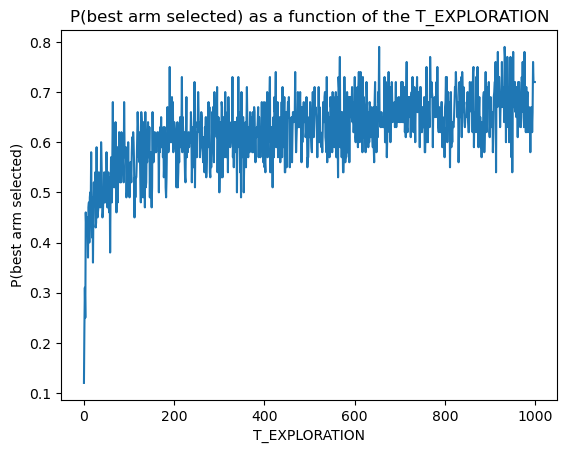

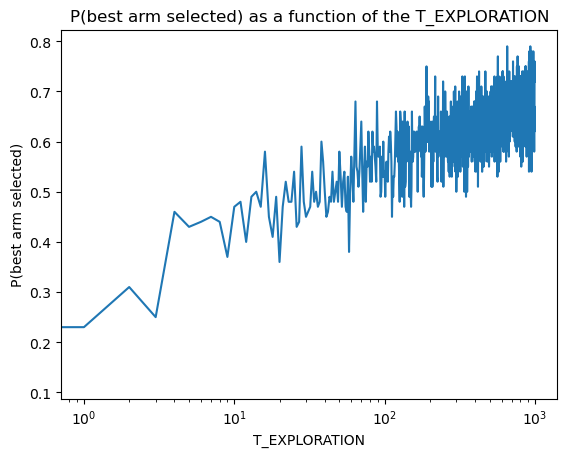

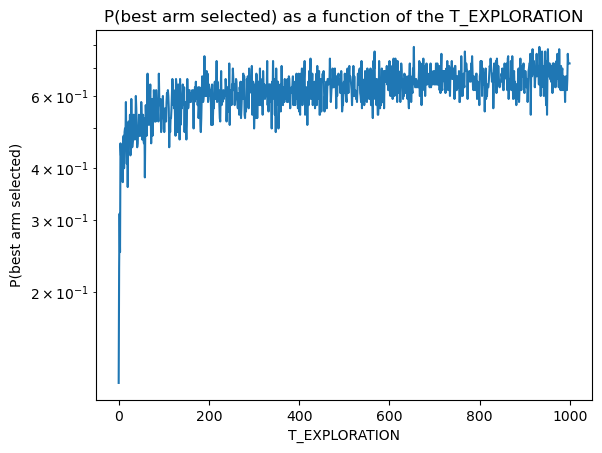

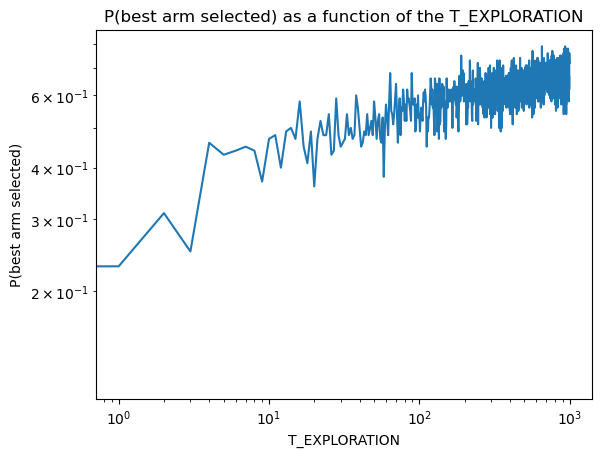

In [332]:
# Run the 'plot_explore_then_commit' function for 5 arms, 10000 throws, a reward of 1, and 100 runs
arm_probs = array_probs[0]
print(array_probs[0])


plot_explore_then_commit(5, 1000, 1000, 1, array_probs[0], 100)